# Using ANN for European style option pricing and calibration purpose

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import standard_normal, seed, uniform, randint
import scipy.stats as stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(42)

##  Case of single asset BS European option

**Reminder: Black Scholes formula for european option and implied volatility**


In the Black-Scholes framework, the stock is assumed to follow a GBM Ito process as follow:

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

where $Z$ is a standard normal random variable.

The principle of portfolio replication leads to a PDE for option price :
$$\frac{ \partial V }{\partial t} + \frac{1}{2}\sigma^2 S^2\frac{ \partial V^2 }{\partial S^2} + rS\frac{ \partial V }{\partial S}-rV = 0$$ with terminal condition $$V(t=T,S) = (S_0 - k)_+$$

For European plain vanilla option, a closed form solution exists as follow for one asset:
$$V_c(t, S)= SN(d_1) - Ke^{-r(T-t)}N(d_2)$$
with : $d_1=\frac{ \log{S/K} + (r-0.5\sigma^2)(T-t) }{\sigma \sqrt{T-t}}$ and $d_2 = d_1 - \sigma \sqrt{T-t}$

**Pricing using MLP**

We will train an MLP regressor to learn the option price from B&S parameters in a supervised learning formulation 

We construct a dataset by independent random sampling of B&S parameters and then compute option price using B&S formula. We construct the variables as follow:

- Explanatory variables : init stock price/strike, time to maturity (yearly fraction), IV, risk free rate
- target variable: European call price/Strike

We then split the dataset in a train and test sample in proportion 70%-30%

1 - **Generating the datasets**

In [2]:
from pricing_utils import bs_call

n_sample = 100000
data = pd.DataFrame()
data['S0/K'] = uniform(low=0.4, high=1.6, size=n_sample)
data['to_maturity'] = uniform(low=0.2, high=1.1, size=n_sample)
data['sigma'] = uniform(low=0.01, high=1, size=n_sample)
data['r'] = uniform(low=0.02, high=0.1, size=n_sample)
data['BS_price/K'] = bs_call(data['S0/K'].values,
                           1, data['r'].values,
                           data['sigma'].values,
                           data['to_maturity'].values)


y = data['BS_price/K']
X = data.drop(columns='BS_price/K')
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.33, random_state=42)

2 - **Calibration of hyperparameters**

For tuning hyperparameters, we use Bayesian optimization implemented by Hyperopt library (tree Parzen algorithm) which is an iterative approach that store all hyperparameters tested during execution.

In [9]:
from ml_models import MLPRegressor
from ml_utils import bayesian_tuning
from sklearn.preprocessing import StandardScaler
from hyperopt import hp, tpe

In [10]:
param_grid = {
    'batch_normalisation': hp.choice('batch_normalisation', [True, False]),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(20, 400, 20)]),
    'activation': hp.choice('activation',['relu', 'tanh', 'linear', 'sigmoid' ]),
    'dropout':  hp.uniform('dropout', 0., 0.5),
    'learning_rate': hp.loguniform('learning_rate',np.log(0.0001), np.log(0.001)),
    'kernel_initializer': hp.choice('kernel_initializer', ['glorot_uniform', 'normal', 'uniform']),
    'beta_1': hp.uniform('beta_1', 0., 0.99),
    'beta_2': hp.uniform('beta_2', 0., 0.99),
}

model = MLPRegressor(
    scaler=StandardScaler(),
    n_feature=4,
    epochs=10,
    batch_size=1024,
    loss="mse",
    verbose=0
)


tuning_output = bayesian_tuning(
           X_train.values,
           y_train.values,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=50,       
           optimizer=tpe.suggest
    )

100%|██████| 50/50 [10:17<00:00, 12.35s/trial, best loss: 0.033642629374347324]



In [11]:
best_params = tuning_output[0]['hyperparameters']
best_params

{'activation': 'linear',
 'batch_normalisation': True,
 'beta_1': 0.6687991182446276,
 'beta_2': 0.48238955010525786,
 'dropout': 0.0563309747410968,
 'hidden_size': 380,
 'kernel_initializer': 'uniform',
 'learning_rate': 0.0008690133934201894}

3 - **Train and test**

In [12]:
model = MLPRegressor(
    scaler=StandardScaler(),
    n_feature=4,
    batch_size=1024,
    epochs=50,
    loss="mse",
    verbose=1
)
model.set_params(**best_params)

model.verbose = 1
starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost train:', endtime - starttime, 'seconds')

Epoch 1/50
7/7 [==============================] - 0s 36ms/step - loss: 0.2030 - mse: 0.2030
Epoch 2/50
7/7 [==============================] - 0s 39ms/step - loss: 0.0853 - mse: 0.0853
Epoch 3/50
7/7 [==============================] - 0s 36ms/step - loss: 0.0659 - mse: 0.0659
Epoch 4/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0582 - mse: 0.0582
Epoch 5/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0498 - mse: 0.0498
Epoch 6/50
7/7 [==============================] - 0s 33ms/step - loss: 0.0422 - mse: 0.0422
Epoch 7/50
7/7 [==============================] - 0s 36ms/step - loss: 0.0376 - mse: 0.0376
Epoch 8/50
7/7 [==============================] - 0s 34ms/step - loss: 0.0339 - mse: 0.0339
Epoch 9/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0307 - mse: 0.0307
Epoch 10/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0277 - mse: 0.0277
Epoch 11/50
7/7 [==============================] - 0s 34ms/step - loss: 0.0247 

In [13]:
y_hat = model.predict(X_train)
starttime = time.time()
y_pred = model.predict(X_test) # nb_path=100 to use Monte-Carlo dropout mean
endtime = time.time()
print('\nTime Cost predict:', endtime - starttime, 'seconds')
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mae on train set', mean_absolute_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))
print('mae on test set', mean_absolute_error(y_test, y_pred))


Time Cost predict: 0.19547748565673828 seconds
mse on train set 0.003212499003754801
mae on train set 0.043120966526488023
mse on test set 0.017491824515753932
mae on test set 0.09389930215576513


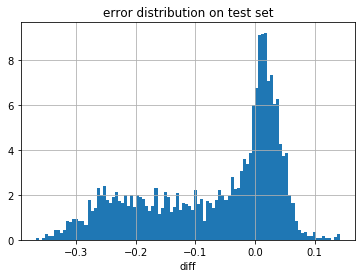

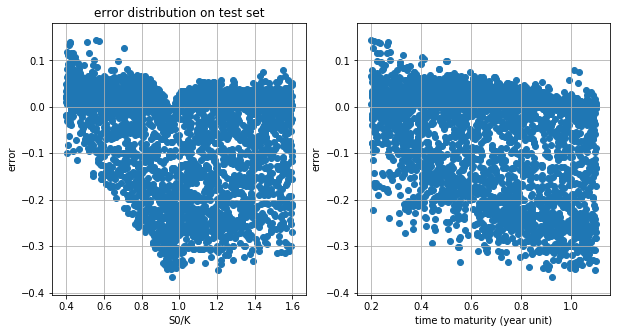

In [14]:
diff = y_test.values - y_pred.ravel()
plt.hist(diff, bins=100, density=True)
plt.xlabel('diff')
plt.title('error distribution on test set')
plt.grid()

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plt.xlabel('S0/K')
plt.ylabel('error')
plt.title('error distribution on test set')
dist = plt.scatter(X_test['S0/K'], diff)
plt.grid()
bx = plt.subplot(122)
plt.xlabel('time to maturity (year unit)')
plt.ylabel('error')
dist = plt.scatter(X_test['to_maturity'], diff)
plt.grid()

We observe that the error is higher close to the money and boundary of of maturity and strike

4 - **Compare with other models**

**Linear Regression**

In [15]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print('mse on test set', mse_test)
print('mae on test set', mae_test)


mse on test set 0.07138825040119176
mae on test set 0.23136208404548672


**Gaussian process regression**

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
reg = GaussianProcessRegressor()
starttime = time.time()
reg.fit(X_train[:10000], y_train[:10000]) # train on 10 000 data point is sufficient 
endtime = time.time()
print('\nTime Cost train:', endtime - starttime, 'seconds')

starttime = time.time()
y_pred = reg.predict(X_test)
endtime = time.time()
print('\nTime Cost predict:', endtime - starttime, 'seconds')
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print('mse on test set', mse_test)
print('mae on test set', mae_test)



Time Cost train: 14.564031600952148 seconds

Time Cost predict: 1.4660766124725342 seconds
mse on test set 0.0002760178380141024
mae on test set 0.011316301183473312


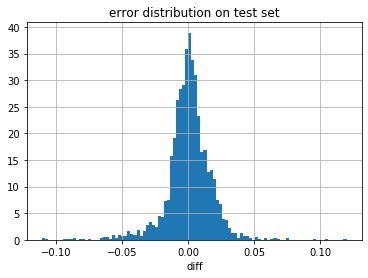

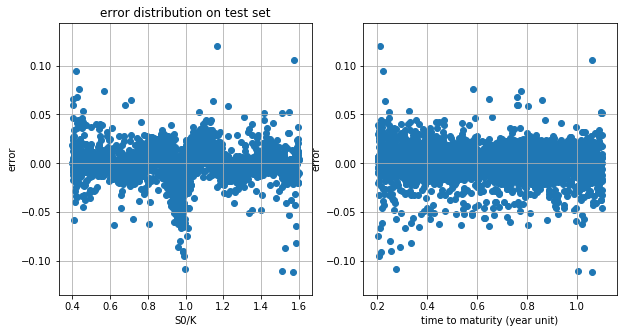

In [17]:
diff = y_test.values - y_pred.ravel()
plt.hist(diff, bins=100, density=True)
plt.xlabel('diff')
plt.title('error distribution on test set')
plt.grid()

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plt.xlabel('S0/K')
plt.ylabel('error')
plt.title('error distribution on test set')
dist = plt.scatter(X_test['S0/K'], diff)
plt.grid()
bx = plt.subplot(122)
plt.xlabel('time to maturity (year unit)')
plt.ylabel('error')
dist = plt.scatter(X_test['to_maturity'], diff)
plt.grid()

5 - **Implied volatility computation**

We now calibrate B&S implied volatility using MLP with observed prices, ie re-compute IV given observed market prices

We construct our dataset by generating call prices using random sampling IV and other parameters and then formulate the following supervised learning problem:

 - Explanatory variables : E call prices/strike, init stock/strike, time to maturity (yearly fraction), risk free rate
 - Target : IV 


In [18]:
data = pd.DataFrame()
data['S0/K'] = uniform(low=0.4, high=1.6, size=10000)
data['to_maturity'] = uniform(low=0.2, high=1.1, size=(len(data)))
data['sigma'] = uniform(low=0.01, high=1, size=len(data)) 
data['r'] = uniform(low=0.02, high=0.1, size=len(data))
data['BS_price/K'] = bs_call(data['S0/K'].values,
                           1, data['r'].values,
                           data['sigma'].values,
                           data['to_maturity'].values) # we generate price using sampled sigma 
# we take the log of option time value for gradient issue
data['log(time_value/K)'] = np.log(data['BS_price/K'] - \
                                   np.maximum(data['S0/K'] - np.exp(-data['r'] * data['to_maturity']), 0))

data = data[data['log(time_value/K)']>-1e7] # drop small values
y = data['sigma']
X = data[['S0/K', 'to_maturity', 'r', 'log(time_value/K)']]
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.33, random_state=42)

C:\Users\langbo\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\langbo\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
model.verbose = 0
tuning_output = bayesian_tuning(
           X_train.values,
           y_train.values,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=50,       
           optimizer=tpe.suggest
    )

starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

y_hat = model.predict(X_train)
y_pred = model.predict(X_test) # nb_path=100 to use Monte-Carlo dropout mean
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mae on train set', mean_absolute_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))
print('mae on test set', mean_absolute_error(y_test, y_pred))

100%|██████| 50/50 [28:55<00:00, 34.72s/trial, best loss: 0.016632149385345994]


Time Cost: 19.56197476387024 seconds
mse on train set 0.054173586395716795
mae on train set 0.200275524155845
mse on test set 0.05393940461506526
mae on test set 0.19879379269521938


In [20]:
from pricing_utils import bs_vol_imp_call

X = data
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.33, random_state=42)
starttime = time.time()
iv_newton = [bs_vol_imp_call(X_test.iloc[i]['S0/K'],
                          1,
                          X_test.iloc[i]['to_maturity'],
                          X_test.iloc[i]['BS_price/K'],
                          X_test.iloc[i]['r'],
                          sigma_init=1) for i in range(len(X_test))]
endtime = time.time()
iv_newton = np.array(iv_newton)
print('\nTime Cost:', endtime - starttime, 'seconds')
print('mse newton on test set', mean_squared_error(y_test, iv_newton))
print('mae newton on test set', mean_absolute_error(y_test, iv_newton))

C:\Users\langbo\Documents\GitHub\SIQEF-RA-2020\SIQEF Assignment\scikit_learn\ml_option_pricing\ml_option_pricing\pricing_utils.py:89: RuntimeWarning: overflow encountered in double_scalars
  xnew = (xnew - fx - V) / vega
C:\Users\langbo\Documents\GitHub\SIQEF-RA-2020\SIQEF Assignment\scikit_learn\ml_option_pricing\ml_option_pricing\pricing_utils.py:87: RuntimeWarning: invalid value encountered in double_scalars
  while abs(xnew - xold) > tol:



Time Cost: 9.078711748123169 seconds


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

6 - **Conclusion**

- Neural network NLP can offer better precision but need high number of sample to be efficiently trained
- Single hidden layer seems sufficient for the case of one asset
- Gaussian process can do better with small dataset but prediction is longer
- The performance can be highly deteriorated for new set of parameters that are close or out of the boundary of the training space

## Case of basket option (Multi-underlying)

**Brief presentation:**

We consider a basket call option on an index $I_t$ given by :
$$I_t = a_1S^1_t + ... + a_dS^d_t$$
where $a_i>0$,  $\sum a_i = 1$ and where each of the d assets follow a GBM:

$dS^i_t=r S^i_tdt+\sigma_i S^i_tdW^i_t\quad\quad$ with $\quad d \langle W^i, W^j\rangle_t = \rho_{ij}dt\quad$ and $\quad \rho_{ij}=\frac{\sum^{d}_{k=1}{\Sigma_{ik}\Sigma_{jk}}}{\sigma_i \sigma_j}$

Under risk-neutral measure

We consider payoff of kind $(I_T - K)_+$

**Monte-Carlo Pricing**

The Feynman-Kac theorem enable to write the option price as the conditional expectation of the discounted terminal payoff under the risk neutral measure and thus we will use Monte-Carlo simulation of stock path to estimate this value. A very basic MC pricer is used, no variance reduction technics

1 - **Generating dataset for 4 assets**

In [21]:
from scipy.stats import random_correlation
from pricing_utils import payoff_call_basket, basket_mc_price

n_sample = 10000
d = 4
N = 10000 #nb path for pricer
data_sample = []
data = []
starttime = time.time()

for n in range(n_sample):
    Rho = random_correlation.rvs((.5, .8, 1.2, 1.5)) 
    sigma = uniform(low=0.01, high=1, size=d)
    Gamma = np.diag(sigma) * Rho * np.diag(sigma)
    Sigma=np.sqrt(Gamma)
    r = uniform(low=0.02, high=0.1)
    T = uniform(low=0.2, high=1.1) # annualized
    a = (1/d)*np.ones(d) # fixed weights 
    S_0 = np.random.lognormal(mean=0.5, sigma=0.25, size=4)
    I_0 = np.dot(a, S_0)
    K = uniform(low=1, high=3) 
    Call_price, _, _ = basket_mc_price(N, S_0/K, 1, r, T, sigma, Sigma, a, fonction_payoff=payoff_call_basket)
    data_sample = np.concatenate([Rho[0,1:], Rho[1,2:], Rho[2,3:], sigma, S_0/K,  [r, T, Call_price]])
    data.append(data_sample)

endtime = time.time()
print('\nTime Cost of MC pricing: ~', (endtime - starttime) * 0.33, 'seconds')

data = pd.DataFrame(data,
                   columns=['rho_12', 'rho_13', 'rho_14','rho_23', 'rho_24', 'rho_34',
                           'sigma_1', 'sigma_2', 'sigma_3', 'sigma_4', 'S1_0/K', 'S2_0/K',
                            'S3_0/K', 'S4_0/K', 'r', 'T', 'Price'])
y = data['Price']
X = data.drop(columns='Price')
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Time Cost of MC pricing: ~ 18.673668973445892 seconds


2 - **MLP pricing**

In [22]:
param_grid = {
    'batch_normalisation': hp.choice('batch_normalisation', [True, False]),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(20, 400, 20)]),
    'hidden_size_2': hp.choice('hidden_size_2',[None] + [int(x) for x in np.linspace(20, 400, 20)]),
    'activation': hp.choice('activation',['relu', 'tanh', 'linear', 'sigmoid' ]),
    'dropout':  hp.uniform('dropout', 0., 0.5),
    'learning_rate': hp.loguniform('learning_rate',np.log(0.0001), np.log(0.001)),
    'kernel_initializer': hp.choice('kernel_initializer', ['glorot_uniform', 'normal', 'uniform']),
    'beta_1': hp.uniform('beta_1', 0., 0.99),
    'beta_2': hp.uniform('beta_2', 0., 0.99),
}

model = MLPRegressor(
    scaler=StandardScaler(),
    n_feature=16,
    epochs=10,
    batch_size=200,
    loss="mse",
    verbose=0
)

tuning_output = bayesian_tuning(
           X_train.values,
           y_train.values,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=50,       
           optimizer=tpe.suggest
    )
best_params = tuning_output[0]['hyperparameters']
print('best_params:')
print(best_params)

 62%|███  | 31/50 [11:22<06:58, 22.01s/trial, best loss: 0.0002110481387029225]


KeyboardInterrupt: 

In [ ]:
model.epochs=100
model.batch_size=1024
model.set_params(**best_params)

starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost training:', endtime - starttime, 'seconds')

y_hat = model.predict(X_train)
starttime = time.time()
y_pred = model.predict(X_test) # nb_path=100 to use Monte-Carlo dropout mean
endtime = time.time()
print('\nTime Cost predict:', endtime - starttime, 'seconds')
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mae on train set', mean_absolute_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))
print('mae on test set', mean_absolute_error(y_test, y_pred))

Error distribution

In [ ]:
diff = y_test.values - y_pred.ravel()

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plt.hist(diff, bins=100, density=True)
plt.xlabel('diff')
plt.title('error distribution on test set')
plt.grid()
plt.grid()
bx = plt.subplot(122)
plt.xlabel('time to maturity (year unit)')
plt.ylabel('error')
dist = plt.scatter(X_test['T'], diff)
plt.grid()

3 - **Gaussian Process pricing**

In [ ]:
reg = GaussianProcessRegressor()
starttime = time.time()
reg.fit(X_train, y_train) 
endtime = time.time()
print('\nTime Cost train:', endtime - starttime, 'seconds')

starttime = time.time()
y_pred = reg.predict(X_test)
endtime = time.time()
print('\nTime Cost predict:', endtime - starttime, 'seconds')
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print('mse on test set', mse_test)
print('mae on test set', mae_test)

6 - **Conclusion**

In this case with more features, using two hidden layers for MLP leads to better performance

## Case of stochastic vol framework

**Model**



The Heston Model is defined as follow (under risk-neutral measure):
$$dS_t=r S_tdt+ \sqrt{v_t} S_tdW^S_t$$
$$dv_t=\kappa (v - v_t)dt+\gamma \sqrt{v_t}dW^v_t$$

$d \langle W^S, W^v\rangle_t = \rho_{Sv}dt\quad$, $\quad S_{t_0}=S_0$, $\quad v_{t_0}=v_0$

Note that we have more than one source of uncertaincy (volatility term parameters) and thus leads to non uniqueness of a risk-neutral price.

**Pricer**

We use here an implementation of the COS method to compute call prices for our study

1 - **Generating dataset**

In [ ]:
from pricing_utils import cos_heston_price

n_sample = 100000
data = pd.DataFrame()
data['S_0/K'] = uniform(low=0.4, high=1.6, size=n_sample)
data['to_maturity'] = uniform(low=0.2, high=1.1, size=n_sample)
data['r'] = uniform(low=0.02, high=0.1, size=n_sample)
data['init_variance'] = uniform(low=0.05, high=1, size=n_sample)
data['mean_variance'] = uniform(low=0.01, high=1, size=n_sample)
data['reversion_speed'] = uniform(low=0.01, high=3, size=n_sample)
data['gamma'] = uniform(low=0.01, high=0.8, size=n_sample)
data['rho'] = uniform(low=-0.9, high=0, size=n_sample)
starttime = time.time()
data['call_price'] = [cos_heston_price(data.iloc[i]['S_0/K'],
                                       1,
                                       data.iloc[i]['r'],
                                       data.iloc[i]['to_maturity'],
                                       data.iloc[i]['mean_variance'],
                                       data.iloc[i]['init_variance'],
                                       data.iloc[i]['reversion_speed'],
                                       data.iloc[i]['gamma'],
                                       data.iloc[i]['rho'],
                                       call=True)
                      for i in range(len(data))]
endtime = time.time()
print('\nTime Cost pricing: ~', (endtime - starttime)/3, 'seconds')

data = data[(data['call_price']>0) & (data['call_price']<1)] #drop extrem values
y = data['call_price']
X = data.drop(columns='call_price')
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
data['call_price'].hist(bins=100)
plt.title('call price distribution')

2 - **Pricing with MLP**

In [ ]:
param_grid = {
    'batch_normalisation': hp.choice('batch_normalisation', [True, False]),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(20, 400, 20)]),
    'hidden_size_2': hp.choice('hidden_size_2',[None] + [int(x) for x in np.linspace(20, 400, 20)]),
    'activation': hp.choice('activation',['relu', 'tanh', 'linear', 'sigmoid' ]),
    'dropout':  hp.uniform('dropout', 0., 0.5),
    'learning_rate': hp.loguniform('learning_rate',np.log(0.0001), np.log(0.001)),
    'kernel_initializer': hp.choice('kernel_initializer', ['glorot_uniform', 'normal', 'uniform']),
    'beta_1': hp.uniform('beta_1', 0., 0.99),
    'beta_2': hp.uniform('beta_2', 0., 0.99),
}
model = MLPRegressor(
    scaler=StandardScaler(),
    n_feature=8,
    epochs=10,
    batch_size=200,
    loss="mse",
    verbose=0
)
tuning_output = calibration(
           X_train,
           y_train,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=50,       
           optimizer=tpe.suggest
    )
best_params = tuning_output[0]['hyperparameters']

In [ ]:
model.epochs=100
model.batch_size=1024
model.set_params(**best_params)
print('hyperparamers used')
print(best_params)

starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost training:', endtime - starttime, 'seconds')

y_hat = model.predict(X_train)
y_pred = model.predict(X_test) # nb_path=100 to use Monte-Carlo dropout mean
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mae on train set', mean_absolute_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))
print('mae on test set', mean_absolute_error(y_test, y_pred))

In [ ]:
diff = y_test.values - y_pred.ravel()

fig = plt.figure(figsize=(15, 9))
plt.subplot(231)
plt.hist(diff, bins=100, density=True)
plt.xlabel('diff')
plt.title('error distribution on test set')
plt.grid()
plt.subplot(232)
plt.xlabel('time to maturity (year unit)')
plt.ylabel('error')
dist = plt.scatter(X_test['to_maturity'], diff)
plt.grid()
plt.subplot(233)
plt.xlabel('S_0/K')
plt.ylabel('error')
dist = plt.scatter(X_test['S_0/K'], diff)
plt.grid()
plt.subplot(234)
plt.xlabel('init_variance')
plt.ylabel('error')
dist = plt.scatter(X_test['init_variance'], diff)
plt.grid()
plt.subplot(235)
plt.xlabel('mean_variance')
plt.ylabel('error')
dist = plt.scatter(X_test['mean_variance'], diff)
plt.grid()
plt.subplot(236)
plt.xlabel('rho')
plt.ylabel('error')
dist = plt.scatter(X_test['rho'], diff)
plt.grid()

2 - **Calibration of Heston parameters with multi-output regression MLP**

An important issue with such incomplete model is to find the Heston paramters that "reflect" the observable liquid option price on market.
Fixing some value such as $K$, $T$ and $r$, and given a range of observed option prices for different init stock price ($S_0$) and init variance ($v_0$) as explanatory variables, is it possible to train a supervise ANN able to predict $(\kappa,v,\gamma, \rho)$ ? And the same but using observed prices of different $T$ for a given init price $S_0$ and init $v_0$

**Generate data**

In [ ]:
from pricing_utils import cos_heston_price

#fix some parameters
K = 100
T = 1
r = 0.1

n_sample = 10000

x_data = np.zeros((n_sample, 10, 10)) # grid of 10x10 different prices
y_data = np.zeros((n_sample, 4))

#first define a space of S_0, v_0 values in which we will sample 10x10 values
init_price = 100 * uniform(low=0.4, high=1.6, size=15)
init_var = uniform(low=0.05, high=1, size=15)

mean_variance = uniform(low=0.01, high=1, size=n_sample)
reversion_speed = uniform(low=0.01, high=3, size=n_sample)
gamma = uniform(low=0.01, high=0.8, size=n_sample)
rho = uniform(low=-0.9, high=0, size=n_sample)

for i in range(n_sample):
    S_0 = np.random.choice(init_price, replace=False, size=10)
    v_0 = np.random.choice(init_var, replace=False, size=10)
    y_data[i,:] = np.array([reversion_speed[i], mean_variance[i], gamma[i], rho[i]])
    x_data[i,::] = np.array([[cos_heston_price(S_0[j], K, r, T,
                                               mean_variance[i],
                                               v_0[k],
                                               reversion_speed[i],
                                               gamma[i],
                                               rho[i],
                                               call=True)
                              for j in range(S_0.shape[0])]
                             for k in range(v_0.shape[0])])
x_data = np.where(x_data>1, 1, x_data)
x_data = np.where(x_data<0, 0, x_data)

**CNN multi-Regression**

In [ ]:
from ml_models import CNNRegressor

X_train, X_test, y_train,  y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 10,10, 1)
X_test = X_test.reshape(X_test.shape[0], 10,10, 1)

param_grid = {
    'learning_rate': hp.loguniform('learning_rate',np.log(1.), np.log(100)),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(500, 1000, 20)]),

}
model = CNNRegressor(
    input_shape=(10,10,1),
    n_output=4,
    epochs=10,
    batch_size=200,
    loss="mse",
    verbose=0
)
tuning_output = bayesian_tuning(
           X_train,
           y_train,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=30,       
           optimizer=tpe.suggest
    )
best_params = tuning_output[0]['hyperparameters']
model.epochs = 100
print('hyperparameters used:')
print(best_params)
starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost training:', endtime - starttime, 'seconds')
y_hat = model.predict(X_train)
y_pred = model.predict(X_test)
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))


**MLP multi-Regression**

In [ ]:
X_train, X_test, y_train,  y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)
X_train = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(-1,X_test.shape[1] * X_test.shape[2])

param_grid = {
    'batch_normalisation': hp.choice('batch_normalisation', [True, False]),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(300, 1000, 20)]),
    'hidden_size_2': hp.choice('hidden_size_2',[None] + [int(x) for x in np.linspace(50, 500, 20)]),
    'activation': hp.choice('activation',['relu', 'tanh', 'linear', 'sigmoid' ]),
    'dropout':  hp.uniform('dropout', 0., 0.3),
    'learning_rate': hp.loguniform('learning_rate',np.log(0.0001), np.log(0.001)),
    'kernel_initializer': hp.choice('kernel_initializer', ['glorot_uniform', 'normal', 'uniform']),
    'beta_1': hp.uniform('beta_1', 0., 0.99),
    'beta_2': hp.uniform('beta_2', 0., 0.99),
}
model = MLPRegressor(
    scaler=StandardScaler(),
    n_feature=100,
    n_output=4,
    epochs=10,
    batch_size=200,
    loss="mse",
    verbose=0
)
tuning_output = bayesian_tuning(
           X_train,
           y_train,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=30,       
           optimizer=tpe.suggest
    )
best_params = tuning_output[0]['hyperparameters']
model.epochs = 100
print('hyperparameters used:')
print(best_params)
model.set_params(**best_params)
starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost training:', endtime - starttime, 'seconds')
y_hat = model.predict(X_train)
y_pred = model.predict(X_test)
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))


In [ ]:
error = pd.DataFrame(mean_absolute_error(y_test, y_pred, multioutput = 'raw_values')).T
error_perc = np.mean(np.divide(np.abs(y_test - y_pred), y_test)*100, axis=0)
error_perc = pd.DataFrame(error_perc).T
error = pd.concat([error, error_perc], axis=0)
error.rename(columns={0:'kappa', 1:'v_mean', 2:'gamma', 3:'rho'}, inplace=True)
error.set_index(np.array(['mae', 'mae%']), inplace=True)
print('abs error for each parameters:')
error

**Use of Monte-Carlo Dropout**

In [ ]:
y_pred, std, conf_inf, conf_sup = model.predict(X_test, nb_path=1000)
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))
print('MLP Monte-Carlo Dropout mean variance:', 'kappa: {}'.format(std[0,:].mean()),
      'v: {}'.format(std[1,:].mean()), 'gamma: {}'.format(std[2,:].mean()) )

**Gaussian Process**

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
reg = GaussianProcessRegressor()
starttime = time.time()
reg.fit(X_train, y_train) # train on 10 000 data point is sufficient 
endtime = time.time()
print('\nTime Cost train:', endtime - starttime, 'seconds')

starttime = time.time()
y_pred = reg.predict(X_test)
endtime = time.time()
print('\nTime Cost predict:', endtime - starttime, 'seconds')
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print('mse on test set', mse_test)
print('mae on test set', mae_test)